# Sect 37: Intro to Time Series

- online-ds-pt-100719pt 
- 05/05/20

## Learning Objectives:

- Learn how to load in timeseries data into pandas
- Learn how to plot timeseries in pandas
- Learn how to resample at different time frequencies
- Learn about types of time series trends and how to remove them.
- Learn about seasonal decomposition

## Questions?

1. From [Visualizing Time Series Data - Lab](https://github.com/learn-co-students/dsc-visualizing-time-series-data-lab-online-ds-pt-100719/tree/solution) Grouper and .groupby()  ….almost understand the difference but … not 100%:
    - What is the output ? 
    - How to ‘see it’  ..

```python
groups_monthly = yr_1990.groupby(pd.Grouper(freq='M'))
# Outputs:
<pandas.core.groupby.generic.DataFrameGroupBy object at 0x0000019376272AC8>
```


<br>

2. ...we access [1] through the .values… while concatonating?
```python
# Add each month to DataFrame as a column
months_1990 = pd.concat([pd.DataFrame(x[1].values) for x in groups_monthly], axis=1)
months_df = pd.DataFrame(months_1990)
```
3. Parameters for various functions: (examples below)
    - How to select the appropriate period using .diff()
    - How to select the appropriate window using .rolling()
    - How to select the appropriate halflife using ..ewm()
    
    

4. Interpreting results from Dickey Fuller test… and understanding the object  in order to understand the code behind obtaining it.
```python
# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
print(dftest)
```



5. Do you just keep layering on the various methods to remove trends?  Is there a helpful order? 



6. Is log-transformed the same as original?  



7. I understand we need the data to be stationary for modeling… but when removing trends, it seems very diluted compared to the original version. The example below is from the [last lab](https://github.com/learn-co-students/dsc-removing-trends-lab-online-ds-pt-100719/tree/solution) uses the exponential rolling mean and differencing….  
    - Is there a way to reverse it back to help interpret results/explain model?
    ```python
data_diff = data_minus_exp_roll_mean.diff(periods=12)
```

# Intro to Time Series

## References

- [Pandas Timeseries Documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html)
- ['Timeseries Offset Aliases'](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases)
- [Anchored Offsets](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#anchored-offsets)


- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timestamp.html

## Working with Time Series

In [1]:
# !pip install -U fsds_100719
# %conda install pandas=0.25.1

from fsds_100719.imports import *

fsds_1007219  v0.7.21 loaded.  Read the docs: https://fsds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds_100719,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


[i] Pandas .iplot() method activated.


In [2]:
mpl.rcParams['figure.figsize'] = (12,6)

### Creating a Time Series from a DataFrame

In [3]:
import os,sys
file = 'https://raw.githubusercontent.com/jirvingphd/fsds_pt_100719_cohort_notes/master/datasets/baltimore_crime_2020.csv'#'../../datasets/baltimore_crime_2020.csv'
df = pd.read_csv(file,low_memory=False,usecols=list(range(16)))
df.head()

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Location 1,Premise,vri_name1,Total Incidents
0,04/25/2020,17:30:00,5A,2400 SHIRLEY AVE,BURGLARY,I,NaN,533.0,NORTHERN,GREENSPRING,-76.657102,39.336238,NaN,ROW/TOWNHOUSE-VAC,NaN,1
1,04/25/2020,02:40:00,5A,2900 MOUNT HOLLY ST,BURGLARY,I,NaN,624.0,NORTHWEST,WINDSOR HILLS,-76.682845,39.319594,NaN,ROW/TOWNHOUSE-VAC,NaN,1
2,04/25/2020,09:30:00,5C,0 N JANNEY ST,BURGLARY,I,NaN,232.0,SOUTHEAST,KRESSON,-76.560665,39.293067,NaN,ROW/TOWNHOUSE-VAC,NaN,1
3,04/25/2020,02:30:00,4E,900 W SARATOGA ST,COMMON ASSAULT,NaN,NaN,712.0,WESTERN,POPPLETON,-76.632368,39.292449,NaN,NaN,NaN,1
4,04/25/2020,15:30:00,6C,3700 BOSTON ST,LARCENY,I,NaN,231.0,SOUTHEAST,CANTON INDUSTRIAL AREA,-76.565150,39.277050,NaN,GROCERY/CONFECTION,NaN,1


In [4]:
## Inspect the value_counts for the different types of crimes
crime_counts = pd.DataFrame({
                             '% of Total':df['Description'].value_counts(normalize=True),
'Count':df['Description'].value_counts()})
crime_counts.style.bar('% of Total')

,% of Total,Count
LARCENY,0.223583,67150
COMMON ASSAULT,0.165148,49600
BURGLARY,0.143539,43110
LARCENY FROM AUTO,0.132375,39757
AGG. ASSAULT,0.108901,32707
AUTO THEFT,0.088088,26456
ROBBERY - STREET,0.0709006,21294
ROBBERY - COMMERCIAL,0.0176869,5312
SHOOTING,0.0132818,3989
ROBBERY - RESIDENCE,0.0103884,3120


## Preparing Data for Time Series Visualization

- Index must be a `datetimeindex`

In [5]:
display(df.head() ,df.index)

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Location 1,Premise,vri_name1,Total Incidents
0,04/25/2020,17:30:00,5A,2400 SHIRLEY AVE,BURGLARY,I,NaN,533.0,NORTHERN,GREENSPRING,-76.657102,39.336238,NaN,ROW/TOWNHOUSE-VAC,NaN,1
1,04/25/2020,02:40:00,5A,2900 MOUNT HOLLY ST,BURGLARY,I,NaN,624.0,NORTHWEST,WINDSOR HILLS,-76.682845,39.319594,NaN,ROW/TOWNHOUSE-VAC,NaN,1
2,04/25/2020,09:30:00,5C,0 N JANNEY ST,BURGLARY,I,NaN,232.0,SOUTHEAST,KRESSON,-76.560665,39.293067,NaN,ROW/TOWNHOUSE-VAC,NaN,1
3,04/25/2020,02:30:00,4E,900 W SARATOGA ST,COMMON ASSAULT,NaN,NaN,712.0,WESTERN,POPPLETON,-76.632368,39.292449,NaN,NaN,NaN,1
4,04/25/2020,15:30:00,6C,3700 BOSTON ST,LARCENY,I,NaN,231.0,SOUTHEAST,CANTON INDUSTRIAL AREA,-76.565150,39.277050,NaN,GROCERY/CONFECTION,NaN,1


RangeIndex(start=0, stop=300336, step=1)

In [6]:
# Make datetime variable
datetime = pd.to_datetime(df['CrimeDate']+ ' - ' + df['CrimeTime'])
datetime 

0        2020-04-25 17:30:00
1        2020-04-25 02:40:00
2        2020-04-25 09:30:00
3        2020-04-25 02:30:00
4        2020-04-25 15:30:00
                 ...        
300331   1978-01-01 10:30:00
300332   1977-05-01 00:01:00
300333   1975-06-01 00:00:00
300334   1969-07-20 21:00:00
300335   1963-10-30 00:00:00
Length: 300336, dtype: datetime64[ns]

In [7]:
## Set dataframe index to be time series
df.set_index(datetime,inplace=True)
df.index

DatetimeIndex(['2020-04-25 17:30:00', '2020-04-25 02:40:00',
               '2020-04-25 09:30:00', '2020-04-25 02:30:00',
               '2020-04-25 15:30:00', '2020-04-25 05:00:00',
               '2020-04-25 22:13:00', '2020-04-25 16:26:00',
               '2020-04-25 21:07:00', '2020-04-25 23:45:00',
               ...
               '1988-05-01 15:00:00', '1985-01-01 00:00:00',
               '1982-08-01 00:01:00', '1981-12-01 16:45:00',
               '1980-07-01 00:01:00', '1978-01-01 10:30:00',
               '1977-05-01 00:01:00', '1975-06-01 00:00:00',
               '1969-07-20 21:00:00', '1963-10-30 00:00:00'],
              dtype='datetime64[ns]', length=300336, freq=None)

In [8]:
## Identify columns to drop/keep
drop_cols = ['CrimeDate','CrimeTime','CrimeCode','Location', 
             'Premise','Post','Neighborhood','Location 1',
             'vri_name1','Total Incidents','Weapon','Inside/Outside']

id_cols = ['Description','Weapon','Longitude','Latitude']

##  Drop unwanted cols
df.drop(columns=drop_cols,inplace=True)
df

,Description,District,Longitude,Latitude
2020-04-25 17:30:00,BURGLARY,NORTHERN,-76.657102,39.336238
2020-04-25 02:40:00,BURGLARY,NORTHWEST,-76.682845,39.319594
2020-04-25 09:30:00,BURGLARY,SOUTHEAST,-76.560665,39.293067
2020-04-25 02:30:00,COMMON ASSAULT,WESTERN,-76.632368,39.292449
2020-04-25 15:30:00,LARCENY,SOUTHEAST,-76.565150,39.277050
...,...,...,...,...
1978-01-01 10:30:00,RAPE,NORTHEAST,-76.582056,39.340492
1977-05-01 00:01:00,RAPE,NORTHERN,-76.626880,39.328817
1975-06-01 00:00:00,RAPE,SOUTHWEST,-76.691297,39.289582
1969-07-20 21:00:00,RAPE,NORTHERN,-76.635300,39.358898


In [9]:
## Get list of crimes to iterate through
crime_types= df['Description'].unique()
crime_types

array(['BURGLARY', 'COMMON ASSAULT', 'LARCENY', 'ROBBERY - STREET',
       'AUTO THEFT', 'AGG. ASSAULT', 'LARCENY FROM AUTO', 'SHOOTING',
       'ROBBERY - RESIDENCE', 'ROBBERY - COMMERCIAL', 'ARSON', 'HOMICIDE',
       'ROBBERY - CARJACKING', 'RAPE'], dtype=object)

In [10]:
## make a dict of all crime types' DataFrames
CRIMES = {}

for crime in crime_types:
    ## get crime df
    group_df  = df.groupby('Description').get_group(crime).copy()
    
    ## Make a column with the crime 
    crime_col = crime.lower()
    group_df[crime_col] = (group_df['Description'] == crime).astype(int)
    group_df.drop(columns=['Description'],inplace=True)

    CRIMES[crime_col] = group_df
CRIMES['shooting']

,District,Longitude,Latitude,shooting
2020-04-25 16:09:00,CENTRAL,-76.623695,39.288378,1
2020-04-24 15:59:00,EASTERN,-76.584030,39.312696,1
2020-04-22 22:30:00,SOUTHWEST,-76.674078,39.273023,1
2020-04-22 17:49:00,EASTERN,-76.581519,39.298946,1
2020-04-22 17:55:00,WESTERN,-76.639655,39.291300,1
...,...,...,...,...
2014-01-05 16:30:00,SOUTHWEST,-76.688085,39.296987,1
2014-01-05 19:41:00,CENTRAL,-76.634616,39.300554,1
2014-01-03 14:32:00,WESTERN,-76.645355,39.289607,1
2014-01-01 17:35:00,NORTHWEST,-76.672260,39.350624,1


In [11]:
## Separate out each indiviudal crime column in new TS dict
TS = {}
for crime,group_df in CRIMES.items():
     TS[crime] = group_df[crime]
        
TS['shooting']

2020-04-25 16:09:00    1
2020-04-24 15:59:00    1
2020-04-22 22:30:00    1
2020-04-22 17:49:00    1
2020-04-22 17:55:00    1
                      ..
2014-01-05 16:30:00    1
2014-01-05 19:41:00    1
2014-01-03 14:32:00    1
2014-01-01 17:35:00    1
2014-01-01 22:31:00    1
Name: shooting, Length: 3989, dtype: int64

In [ ]:
TS['shooting'].index

## Visualizing Time Series

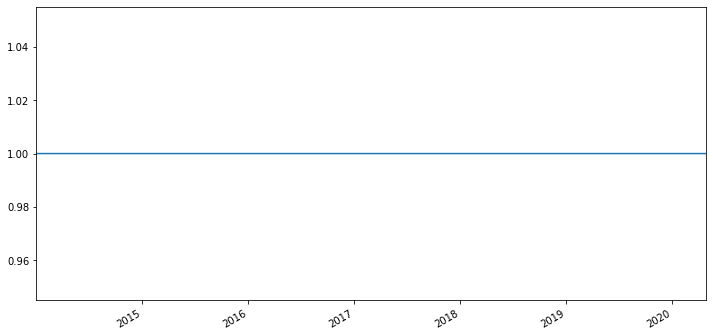

In [12]:
ts = TS['shooting']
ts.plot()

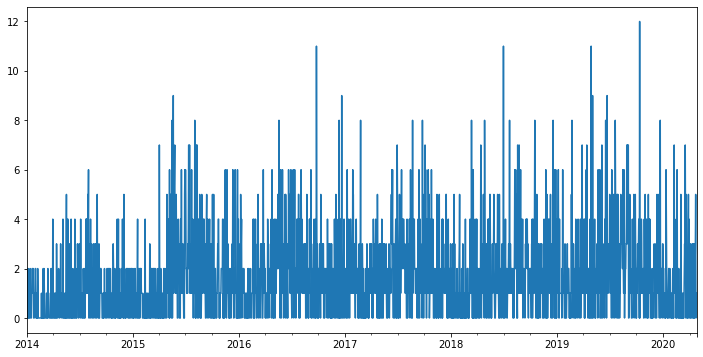

In [13]:
ts = TS['shooting'].resample('D').sum().asfreq('D')
ts.plot()


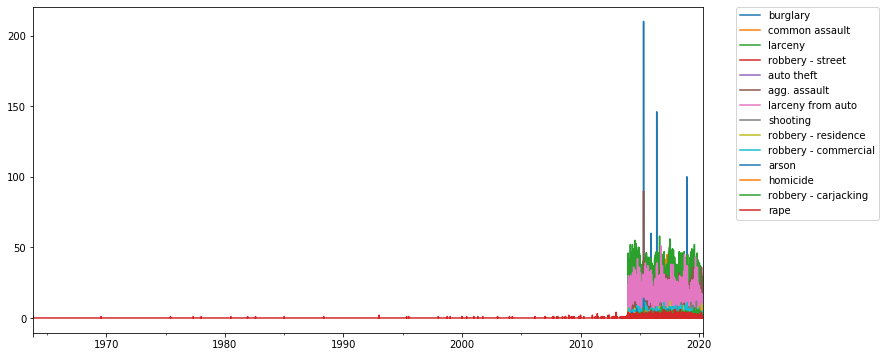

In [18]:
fig,ax = plt.subplots()
for crime in CRIMES:
    ts = TS[crime].resample('D').sum()
    ts.plot(label=crime)
    
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


### Slicing With Time Series

- Make sure you're index is sorted first'
- Feed in 2 dates as strings for slicing.
- Always use .loc when slicing dates

In [15]:
df.sort_index(inplace=True)
df.index

DatetimeIndex(['1963-10-30 00:00:00', '1969-07-20 21:00:00',
               '1975-06-01 00:00:00', '1977-05-01 00:01:00',
               '1978-01-01 10:30:00', '1980-07-01 00:01:00',
               '1981-12-01 16:45:00', '1982-08-01 00:01:00',
               '1985-01-01 00:00:00', '1988-05-01 15:00:00',
               ...
                               'NaT',                 'NaT',
                               'NaT',                 'NaT',
                               'NaT',                 'NaT',
                               'NaT',                 'NaT',
                               'NaT',                 'NaT'],
              dtype='datetime64[ns]', length=300336, freq=None)

//anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning:

Attempting to set identical left == right == 16071.0 results in singular transformations; automatically expanding.



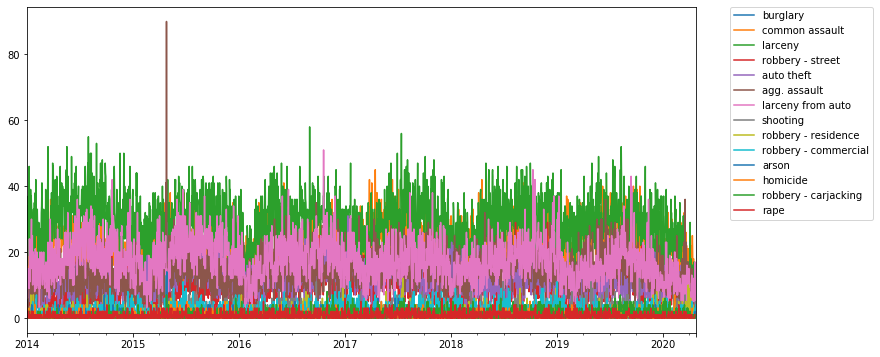

In [17]:
## Slice from 2014 to present
fig,ax = plt.subplots()
for crime in CRIMES:
    ts = TS[crime].loc['2014':].resample('D').sum()
    ts.plot(label=crime)
    
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


In [19]:
ts = TS['shooting'].loc['2014':].resample('D').sum()
ts

2014-01-01    2
2014-01-02    0
2014-01-03    1
2014-01-04    0
2014-01-05    2
             ..
2020-04-21    3
2020-04-22    5
2020-04-23    0
2020-04-24    1
2020-04-25    1
Freq: D, Name: shooting, Length: 2307, dtype: int64

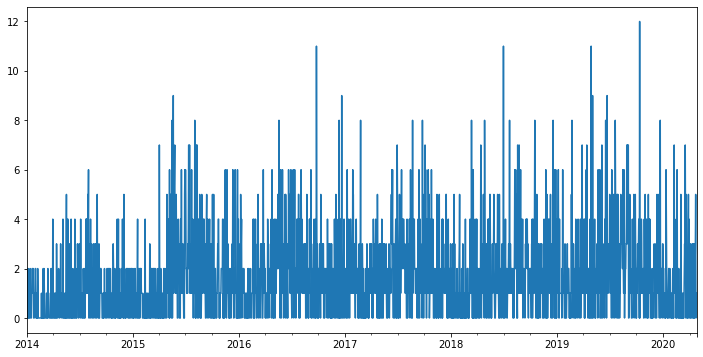

In [20]:
ts.plot()

## Time series Frequencies


In [21]:
ts.index

DatetimeIndex(['2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04',
               '2014-01-05', '2014-01-06', '2014-01-07', '2014-01-08',
               '2014-01-09', '2014-01-10',
               ...
               '2020-04-16', '2020-04-17', '2020-04-18', '2020-04-19',
               '2020-04-20', '2020-04-21', '2020-04-22', '2020-04-23',
               '2020-04-24', '2020-04-25'],
              dtype='datetime64[ns]', length=2307, freq='D')

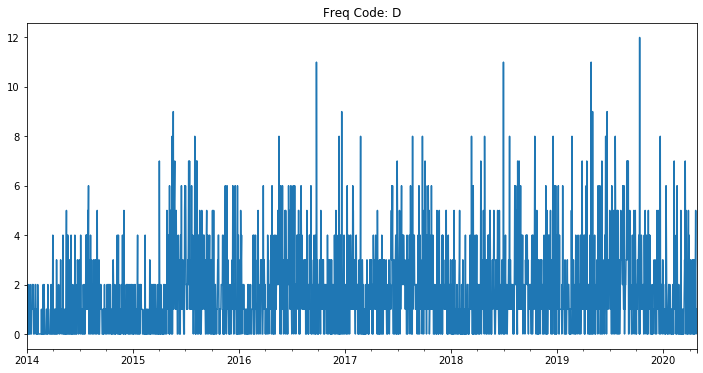

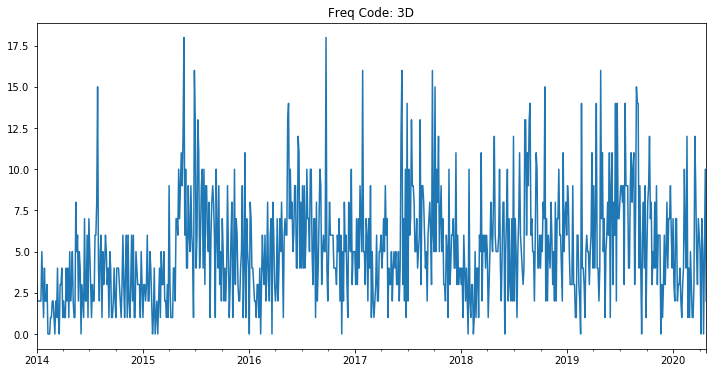

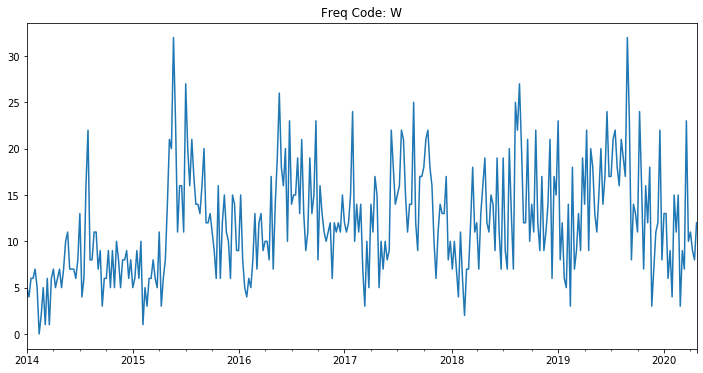

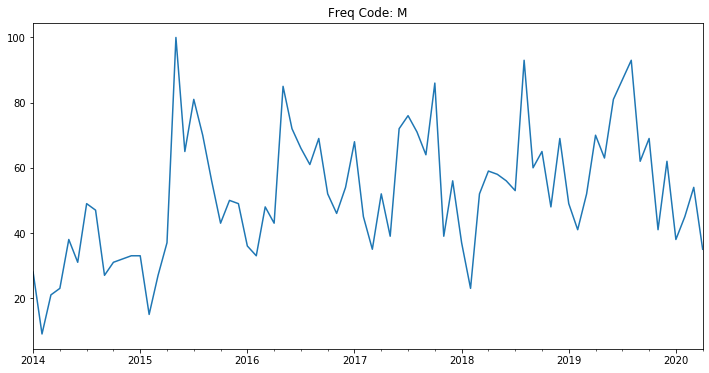

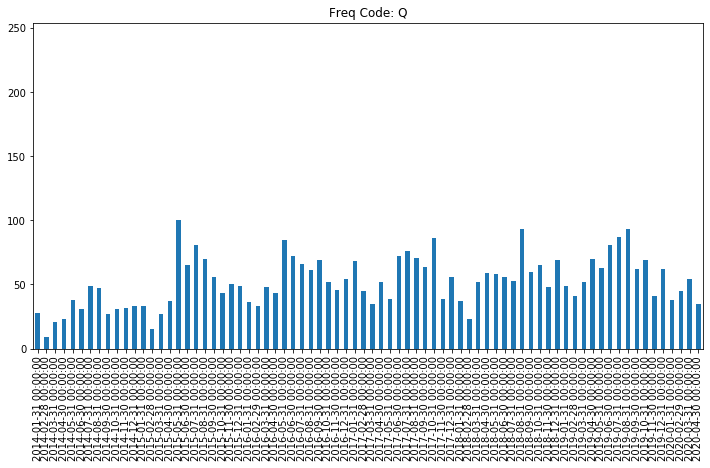

In [25]:
freq_codes = ['D','3D','W','M', 'Q']
for freq in freq_codes:
    plt.figure()
    title=f"Freq Code: {freq}"
    ts.resample(freq).sum().plot(title=title)
    
ax = ts.resample('M').sum().plot(kind='bar')

## Using Datetime objects and apply statemements

In [27]:
display(df.head())
df.dtypes

,Description,District,Longitude,Latitude
1963-10-30 00:00:00,RAPE,NORTHWEST,-76.702636,39.326875
1969-07-20 21:00:00,RAPE,NORTHERN,-76.635300,39.358898
1975-06-01 00:00:00,RAPE,SOUTHWEST,-76.691297,39.289582
1977-05-01 00:01:00,RAPE,NORTHERN,-76.626880,39.328817
1978-01-01 10:30:00,RAPE,NORTHEAST,-76.582056,39.340492


Description     object
District        object
Longitude      float64
Latitude       float64
dtype: object

In [28]:
t = df.index.to_series()[0]
display(t)
print(t)

Timestamp('1963-10-30 00:00:00')

1963-10-30 00:00:00


In [29]:
# help(t.strptime)

In [30]:
print(t.strftime("%m-%d-%Y"))
print(t.strftime("%T"))

10-30-1963
00:00:00


In [31]:
df.index

DatetimeIndex(['1963-10-30 00:00:00', '1969-07-20 21:00:00',
               '1975-06-01 00:00:00', '1977-05-01 00:01:00',
               '1978-01-01 10:30:00', '1980-07-01 00:01:00',
               '1981-12-01 16:45:00', '1982-08-01 00:01:00',
               '1985-01-01 00:00:00', '1988-05-01 15:00:00',
               ...
                               'NaT',                 'NaT',
                               'NaT',                 'NaT',
                               'NaT',                 'NaT',
                               'NaT',                 'NaT',
                               'NaT',                 'NaT'],
              dtype='datetime64[ns]', length=300336, freq=None)

In [32]:
df['month'] = df.index.to_series().apply(lambda x: x.month)
df.head()


,Description,District,Longitude,Latitude,month
1963-10-30 00:00:00,RAPE,NORTHWEST,-76.702636,39.326875,10.0
1969-07-20 21:00:00,RAPE,NORTHERN,-76.635300,39.358898,7.0
1975-06-01 00:00:00,RAPE,SOUTHWEST,-76.691297,39.289582,6.0
1977-05-01 00:01:00,RAPE,NORTHERN,-76.626880,39.328817,5.0
1978-01-01 10:30:00,RAPE,NORTHEAST,-76.582056,39.340492,1.0


In [35]:
df.isna().sum()

Description       0
District          0
Longitude      1678
Latitude       1678
month            25
month_int        25
dtype: int64

In [37]:
## Let's make a month column to groupby
df['month_int'] = df.index.to_series().apply(lambda x: x.month) #x
# df['month_name'] =df.index.to_series().apply(lambda x:x.strftime("%B"))

for col in ['month_int']:
    display(df[col].value_counts(normalize=True))

8.0     0.088512
10.0    0.087989
7.0     0.087786
1.0     0.086147
6.0     0.085764
5.0     0.085605
9.0     0.085518
4.0     0.082807
3.0     0.080077
11.0    0.079777
12.0    0.078898
2.0     0.071120
Name: month_int, dtype: float64

In [ ]:
# url = "https://en.wikipedia.org/wiki/2015_Baltimore_protests"
# pre_riot = crime_2014.loc['2015':'2016']
# pre_riot

In [38]:
df.index.to_series().apply(lambda x: x.month)

1963-10-30 00:00:00    10.0
1969-07-20 21:00:00     7.0
1975-06-01 00:00:00     6.0
1977-05-01 00:01:00     5.0
1978-01-01 10:30:00     1.0
                       ... 
NaT                     NaN
NaT                     NaN
NaT                     NaN
NaT                     NaN
NaT                     NaN
Length: 300336, dtype: float64

In [39]:
help(ax.xaxis.set_ticklabels)

Help on method set_ticklabels in module matplotlib.axis:

set_ticklabels(ticklabels, *args, minor=False, **kwargs) method of matplotlib.axis.XAxis instance
    Set the text values of the tick labels.
    
    Parameters
    ----------
    ticklabels : sequence of str or of `Text`\s
        List of texts for tick labels; must include values for non-visible
        labels.
    minor : bool
        If True, set minor ticks instead of major ticks.
    **kwargs
        Text properties.
    
    Returns
    -------
    labels : list of `Text`\s
        For each tick, includes ``tick.label1`` if it is visible, then
        ``tick.label2`` if it is visible, in that order.



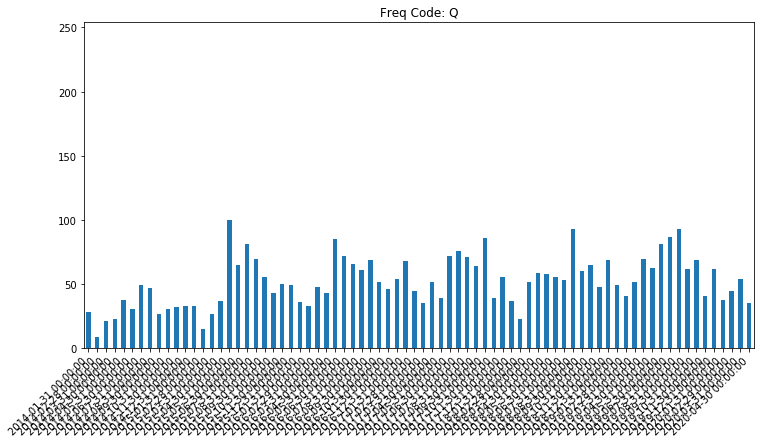

In [40]:
fig = ax.get_figure()

ax.xaxis.set_ticklabels(ax.xaxis.get_ticklabels(),**{'rotation':45,
                                                    'ha':'right'}) 
fig

## Time Series Calculations


### Rolling Statistics

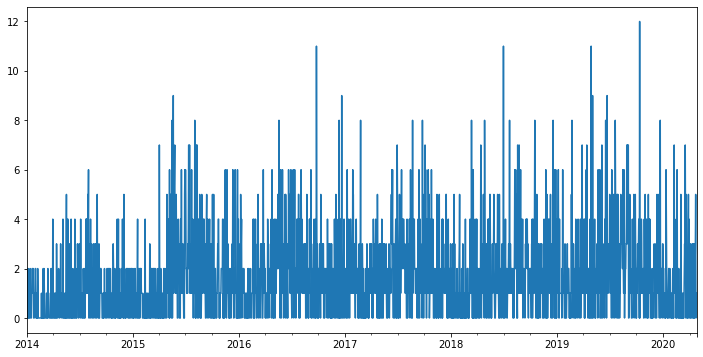

In [44]:
ts_mean = ts.resample('D').mean()
ts_mean.rolling(window=7).mean().head(20)
ts_mean.plot()

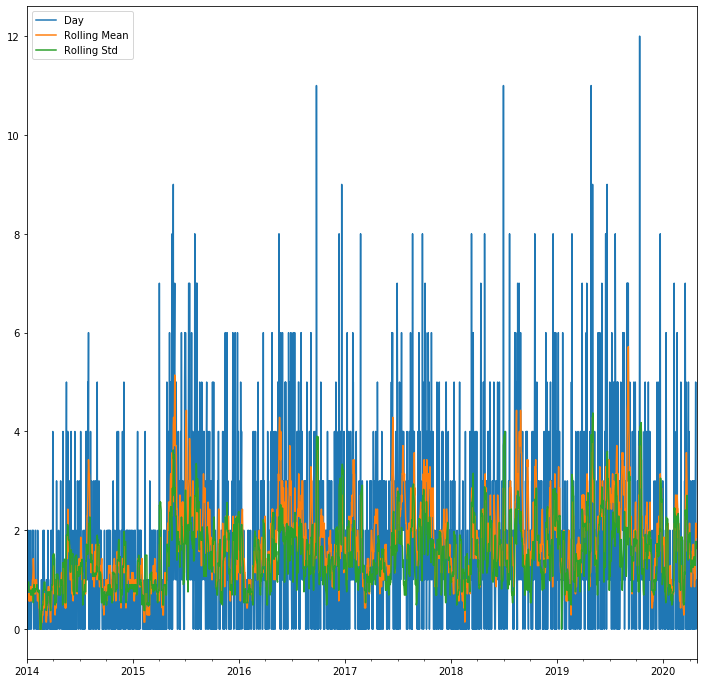

In [45]:
plt.figure(figsize=(12,12))
ts_mean = ts.resample('D').mean()
ts_mean.plot(label='Day')

ts_mean.rolling(window=7).mean().plot(label='Rolling Mean')
ts_mean.rolling(window=7).std().plot(label='Rolling Std')

plt.legend()

In [46]:
ts_mean.fillna(method='ffill',inplace=True)

In [47]:
from statsmodels.tsa.stattools import adfuller
adfuller(ts_mean)#.fillna(method='ffill'))


(-5.815298074240115,
 4.306513222070654e-07,
 20,
 2286,
 {'1%': -3.4332138049681986,
  '5%': -2.8628051617696735,
  '10%': -2.5674435034050314},
 8867.305925849785)

In [48]:
## Lab Function
def stationarity_check(TS,plot=True,col=None):
    """From: https://learn.co/tracks/data-science-career-v2/module-4-a-complete-data-science-project-using-multiple-regression/working-with-time-series-data/time-series-decomposition
    """
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller

    if col is not None:
        # Perform the Dickey Fuller Test
        dftest = adfuller(TS[col]) # change the passengers column as required 
    else:
        dftest=adfuller(TS)
 
    if plot:
        # Calculate rolling statistics
        rolmean = TS.rolling(window = 8, center = False).mean()
        rolstd = TS.rolling(window = 8, center = False).std()

        #Plot rolling statistics:
        fig = plt.figure(figsize=(12,6))
        orig = plt.plot(TS, color='blue',label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label = 'Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
#     plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print ('Results of Dickey-Fuller Test:')

    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
    dfoutput['sig'] = dfoutput['p-value']<.05
    print (dfoutput)
    
    return dfoutput

Results of Dickey-Fuller Test:
Test Statistic                -5.815298e+00
p-value                        4.306513e-07
#Lags Used                     2.000000e+01
Number of Observations Used    2.286000e+03
Critical Value (1%)           -3.433214e+00
Critical Value (5%)           -2.862805e+00
Critical Value (10%)          -2.567444e+00
sig                            1.000000e+00
dtype: float64


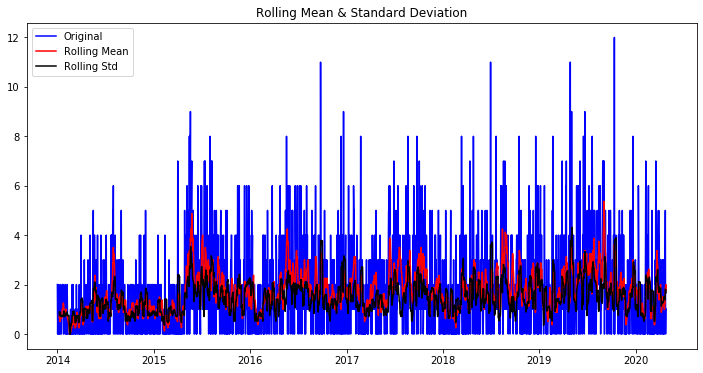

In [49]:
stationarity_check(ts_mean);

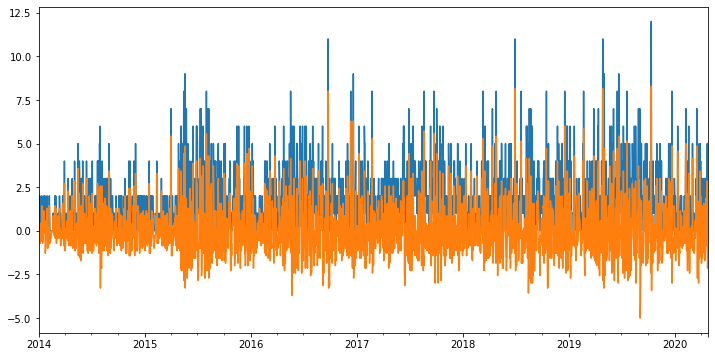

In [50]:
ts_cleaned = ts_mean-ts_mean.rolling(7).mean()
ts_mean.plot()
ts_cleaned.plot()

## Time Series Trends

<img src="https://raw.githubusercontent.com/learn-co-students/dsc-removing-trends-online-ds-ft-100719/master/images/new_trendseasonal.png" width=50%>

### Stationarity

<div style="text-align:center;font-size:2em">Mean</div>
    
<img src="https://raw.githubusercontent.com/jirvingphd/dsc-types-of-trends-online-ds-ft-100719/master/images/new_mean_nonstationary.png" width=70%>
<br><br>
<div style="text-align:center;font-size:3em">Variance</div>
<img src="https://raw.githubusercontent.com/jirvingphd/dsc-types-of-trends-online-ds-ft-100719/master/images/new_cov_nonstationary.png" width=70%>
</div>

### Types of Trends


- https://learn.co/tracks/data-science-career-v2/module-4-a-complete-data-science-project-using-multiple-regression/working-with-time-series-data/types-of-trends

### Removing Trends 
- .diff()
- subtract rolling mean
- seasonal decomposition

## Grouper

In [ ]:
# grouper = ts.groupby(pd.Grouper(freq='A'))
# plot_ts = {}
# for (group,data) in grouper:
#     display(group.year)
#     plot_ts[group.year] = data

## New ts datasets to test

In [51]:
# baltimore_crime ="https://raw.githubusercontent.com/jirvingphd/fsds_100719/master/fsds_100719/data/BPD_Part_1_Victim_Based_Crime_Data.csv"
# std_rates = "https://raw.githubusercontent.com/jirvingphd/fsds_100719/master/fsds_100719/data/STD%20Cases.csv"
# no_sex_xlsx = "https://raw.githubusercontent.com/jirvingphd/fsds_100719/master/fsds_100719/data/Americans%20Sex%20Frequency.xlsx"

learn_passengers="https://raw.githubusercontent.com/learn-co-students/dsc-removing-trends-lab-online-ds-ft-100719/master/passengers.csv"

## Baltimore Crime

In [52]:
baltimore_crime ="https://raw.githubusercontent.com/jirvingphd/fsds_100719/master/fsds_100719/data/BPD_Part_1_Victim_Based_Crime_Data.csv"
df = pd.read_csv(baltimore_crime,low_memory=False,parse_dates=True)
df.sort_index(inplace=True)
df.head()

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Location 1,Premise,vri_name1,Total Incidents
0,12/14/2019,00:26:00,1A,2400 W BELVEDERE AV,HOMICIDE,Outside,FIREARM,532,NORTHERN,LEVINDALE,-77.0,39.0,NaN,HOSPITAL,NaN,1
1,12/14/2019,07:30:00,3B,600 S MONROE ST,ROBBERY - STREET,O,NaN,934,SOUTHERN,CARROLLTON RIDGE,-77.0,39.0,NaN,STREET,NaN,1
2,12/14/2019,14:30:00,3JK,3000 E MONUMENT ST,ROBBERY - RESIDENCE,I,KNIFE,333,EASTERN,ELLWOOD PARK/MONUMEN,-77.0,39.0,NaN,ROW/TOWNHOUSE-OCC,NaN,1
3,12/14/2019,14:15:00,4A,1100 MCCULLOH ST,AGG. ASSAULT,O,FIREARM,123,CENTRAL,LOWER HERRING RUN PARK,-77.0,39.0,NaN,STREET,NaN,1
4,12/14/2019,04:03:00,5E,400 E BELVEDERE AVE,BURGLARY,O,NaN,523,NORTHERN,ROSEBANK,-77.0,39.0,NaN,OTHER - OUTSIDE,NaN,1


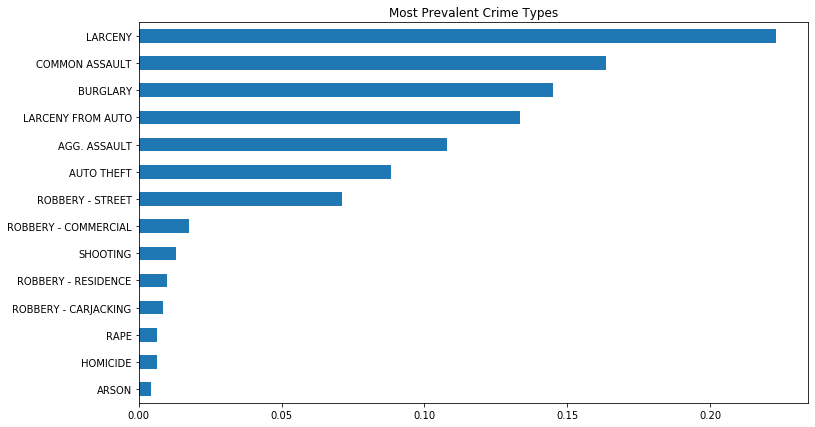

In [53]:
plot_kws= {'title':'Most Prevalent Crime Types','figsize':(12,7)}#,
df["Description"].value_counts(ascending=True,
                              normalize=True).plot(kind='barh',**plot_kws)

In [54]:
df['date'] = pd.to_datetime(df['CrimeDate'])
df.set_index('date',inplace=True)
df.sort_index(inplace=True)

In [55]:
df

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Location 1,Premise,vri_name1,Total Incidents
date,,,,,,,,,,,,,,,,
1963-10-30,10/30/1963,00:00:00,2A,3100 FERNDALE AVE,RAPE,I,OTHER,622,NORTHWEST,HOWARD PARK,-77.0,39.0,NaN,ROW/TOWNHOUSE-OCC,NaN,1
1969-07-20,07/20/1969,21:00:00,2A,5400 ROLAND AVE,RAPE,NaN,OTHER,534,NORTHERN,ROLAND PARK,-77.0,39.0,NaN,NaN,NaN,1
1975-06-01,06/01/1975,00:00:00,2A,4400 OLD FREDERICK RD,RAPE,I,OTHER,822,SOUTHWEST,UPLANDS,-77.0,39.0,NaN,OTHER - INSIDE,NaN,1
1977-05-01,05/01/1977,00:01:00,2A,600 W 34TH ST,RAPE,I,OTHER,531,NORTHERN,WYMAN PARK,-77.0,39.0,NaN,ROW/TOWNHOUSE-OCC,NaN,1
1978-01-01,01/01/1978,10:30:00,2A,1900 ARGONNE DR,RAPE,I,OTHER,421,NORTHEAST,MORGAN STATE UNIVERS,-77.0,39.0,NaN,ROW/TOWNHOUSE-OCC,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-14,12/14/2019,01:05:00,4E,300 S CHARLES ST,COMMON ASSAULT,I,NaN,113,CENTRAL,INNER HARBOR,-77.0,39.0,NaN,HOTEL/MOTEL,NaN,1
2019-12-14,12/14/2019,10:30:00,4D,3200 N HILTON ST,AGG. ASSAULT,I,HANDS,623,NORTHWEST,FOREST PARK,-77.0,39.0,NaN,ROW/TOWNHOUSE-OCC,NaN,1
2019-12-14,12/14/2019,00:52:00,6E,1700 N CALHOUN ST,LARCENY,O,NaN,734,WESTERN,SANDTOWN-WINCHESTER,-77.0,39.0,NaN,STREET,Western,1


## Getting Dummies of Crime Types for Counts

In [56]:
df_crimes = pd.get_dummies(df,columns=['Description'])

crime_cols = [col for col in df_crimes.columns if 'Description_' in col]
new_names = [x.replace('Description_','') for x in crime_cols]

rename_dict = dict(zip(crime_cols,new_names))
df_crimes.rename(rename_dict,axis=1,inplace=True)

df_crimes

,CrimeDate,CrimeTime,CrimeCode,Location,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,...,COMMON ASSAULT,HOMICIDE,LARCENY,LARCENY FROM AUTO,RAPE,ROBBERY - CARJACKING,ROBBERY - COMMERCIAL,ROBBERY - RESIDENCE,ROBBERY - STREET,SHOOTING
date,,,,,,,,,,,,,,,,,,,,,
1963-10-30,10/30/1963,00:00:00,2A,3100 FERNDALE AVE,I,OTHER,622,NORTHWEST,HOWARD PARK,-77.0,...,0,0,0,0,1,0,0,0,0,0
1969-07-20,07/20/1969,21:00:00,2A,5400 ROLAND AVE,NaN,OTHER,534,NORTHERN,ROLAND PARK,-77.0,...,0,0,0,0,1,0,0,0,0,0
1975-06-01,06/01/1975,00:00:00,2A,4400 OLD FREDERICK RD,I,OTHER,822,SOUTHWEST,UPLANDS,-77.0,...,0,0,0,0,1,0,0,0,0,0
1977-05-01,05/01/1977,00:01:00,2A,600 W 34TH ST,I,OTHER,531,NORTHERN,WYMAN PARK,-77.0,...,0,0,0,0,1,0,0,0,0,0
1978-01-01,01/01/1978,10:30:00,2A,1900 ARGONNE DR,I,OTHER,421,NORTHEAST,MORGAN STATE UNIVERS,-77.0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-14,12/14/2019,01:05:00,4E,300 S CHARLES ST,I,NaN,113,CENTRAL,INNER HARBOR,-77.0,...,1,0,0,0,0,0,0,0,0,0
2019-12-14,12/14/2019,10:30:00,4D,3200 N HILTON ST,I,HANDS,623,NORTHWEST,FOREST PARK,-77.0,...,0,0,0,0,0,0,0,0,0,0
2019-12-14,12/14/2019,00:52:00,6E,1700 N CALHOUN ST,O,NaN,734,WESTERN,SANDTOWN-WINCHESTER,-77.0,...,0,0,1,0,0,0,0,0,0,0


___

In [57]:
keep_cols = ['CrimeDate','CrimeTime']
keep_cols.extend(new_names)

keep_cols

['CrimeDate',
 'CrimeTime',
 'AGG. ASSAULT',
 'ARSON',
 'AUTO THEFT',
 'BURGLARY',
 'COMMON ASSAULT',
 'HOMICIDE',
 'LARCENY',
 'LARCENY FROM AUTO',
 'RAPE',
 'ROBBERY - CARJACKING',
 'ROBBERY - COMMERCIAL',
 'ROBBERY - RESIDENCE',
 'ROBBERY - STREET',
 'SHOOTING']

In [58]:
df_crimes = df_crimes.loc["2014":]
df_crimes.index

DatetimeIndex(['2014-01-01', '2014-01-01', '2014-01-01', '2014-01-01',
               '2014-01-01', '2014-01-01', '2014-01-01', '2014-01-01',
               '2014-01-01', '2014-01-01',
               ...
               '2019-12-14', '2019-12-14', '2019-12-14', '2019-12-14',
               '2019-12-14', '2019-12-14', '2019-12-14', '2019-12-14',
               '2019-12-14', '2019-12-14'],
              dtype='datetime64[ns]', name='date', length=286528, freq=None)

In [59]:
df_crimes= df_crimes.loc["2014":][keep_cols]
display(df_crimes.index)

DatetimeIndex(['2014-01-01', '2014-01-01', '2014-01-01', '2014-01-01',
               '2014-01-01', '2014-01-01', '2014-01-01', '2014-01-01',
               '2014-01-01', '2014-01-01',
               ...
               '2019-12-14', '2019-12-14', '2019-12-14', '2019-12-14',
               '2019-12-14', '2019-12-14', '2019-12-14', '2019-12-14',
               '2019-12-14', '2019-12-14'],
              dtype='datetime64[ns]', name='date', length=286528, freq=None)

___

In [60]:
# df_crimes['LARCENY'].plot()

## `pd.grouper`

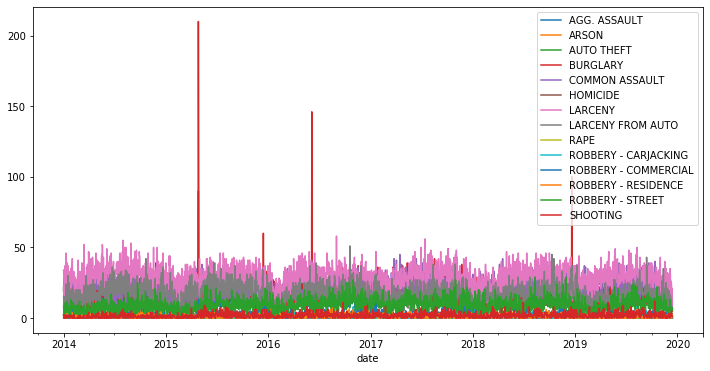

In [61]:
## Traditional Groupby
df_crimes.groupby(pd.Grouper(freq='D')).sum()[new_names].plot(figsize=(12,6)).autoscale()

In [62]:
df_crimes.index

DatetimeIndex(['2014-01-01', '2014-01-01', '2014-01-01', '2014-01-01',
               '2014-01-01', '2014-01-01', '2014-01-01', '2014-01-01',
               '2014-01-01', '2014-01-01',
               ...
               '2019-12-14', '2019-12-14', '2019-12-14', '2019-12-14',
               '2019-12-14', '2019-12-14', '2019-12-14', '2019-12-14',
               '2019-12-14', '2019-12-14'],
              dtype='datetime64[ns]', name='date', length=286528, freq=None)

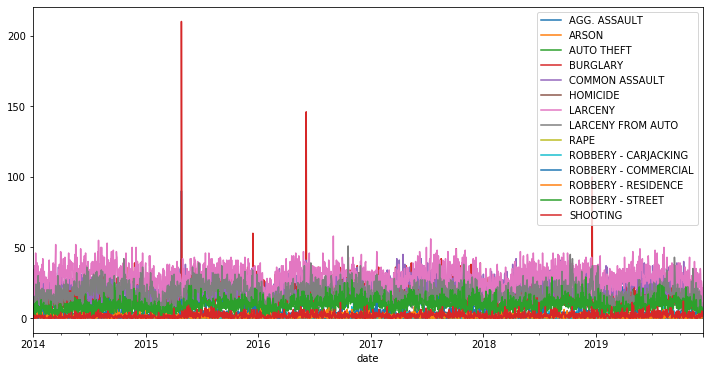

In [63]:
df_crimes.groupby(pd.Grouper(freq='D')).sum().plot()

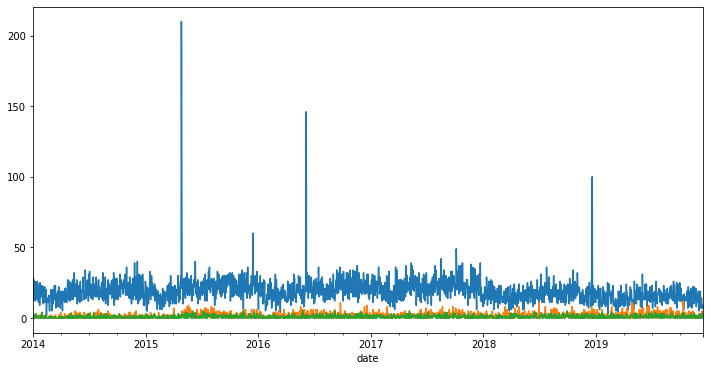

In [64]:
df_crimes['BURGLARY'].resample('D').sum().plot()
df_crimes['SHOOTING'].resample('D').sum().plot()
df_crimes['HOMICIDE'].resample('D').sum().plot()


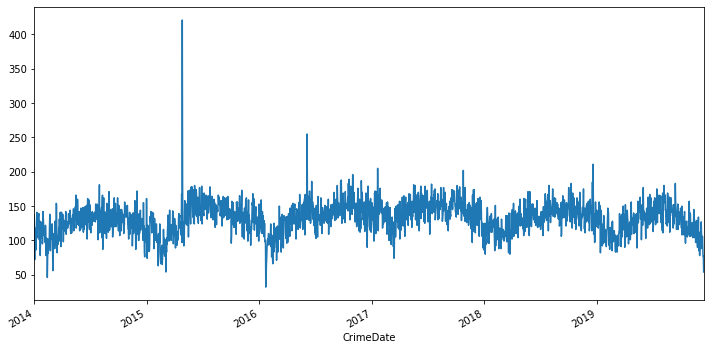

In [65]:
df_counts = df_crimes.groupby('CrimeDate').count()[new_names]
df_counts.index = pd.to_datetime(df_counts.index)
df_counts['BURGLARY'].plot()

In [66]:
df_counts.sort_index(inplace=True)

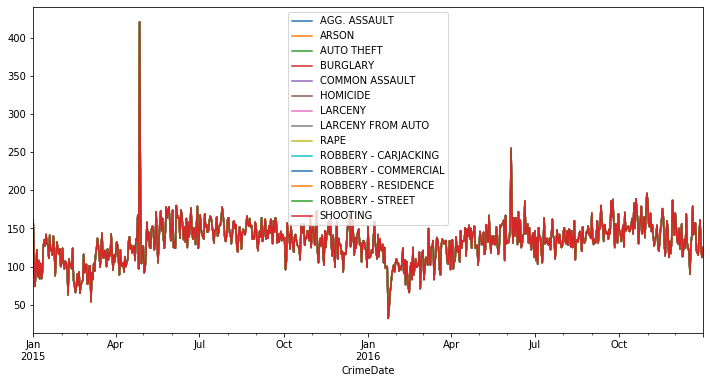

In [67]:
# df_counts.loc['2014':].plot()
# plt.legend(None)
df_2015 = df_counts.loc['2015':'2016']
ax = df_2015.plot()
fig=ax.get_figure()

In [68]:
riots_start ='2015-04-18' 
ax.axvline(riots_start)

riots_end = '2015-05-03' 
ax.axvline(riots_end)

ax.set_xlim(riots_start,riots_end)

(16543, 16558)

In [69]:
df_2015.idxmax()

AGG. ASSAULT           2015-04-27
ARSON                  2015-04-27
AUTO THEFT             2015-04-27
BURGLARY               2015-04-27
COMMON ASSAULT         2015-04-27
HOMICIDE               2015-04-27
LARCENY                2015-04-27
LARCENY FROM AUTO      2015-04-27
RAPE                   2015-04-27
ROBBERY - CARJACKING   2015-04-27
ROBBERY - COMMERCIAL   2015-04-27
ROBBERY - RESIDENCE    2015-04-27
ROBBERY - STREET       2015-04-27
SHOOTING               2015-04-27
dtype: datetime64[ns]

# Seasonal Decomposition

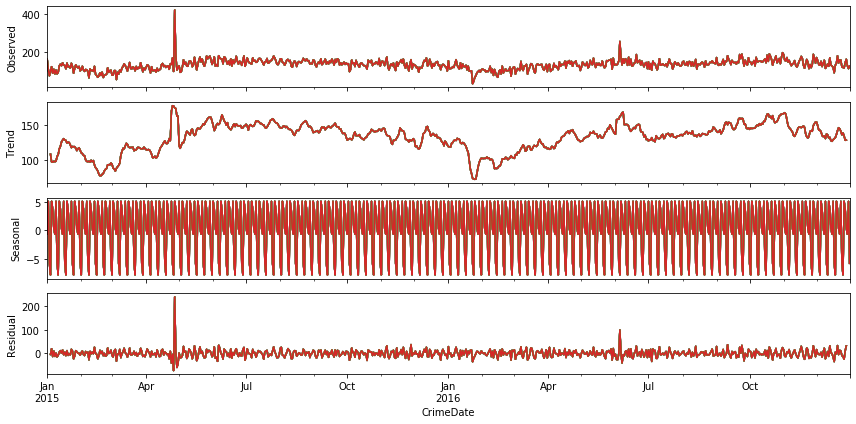

In [70]:
from statsmodels.tsa.seasonal import seasonal_decompose
seasonal_decompose(df_2015).plot();

In [71]:
# url = "https://en.wikipedia.org/wiki/2015_Baltimore_protests"
# pre_riot = crime_2014.loc['2015':'2016']
# pre_riot

# APPENDIX

## Date Formatting References

**REFERENCE CONTENTS:**
- Date StrFormatting
    - Used for:
        - Recognizing Date Formats (`pd.to_datetime`)
        - `dt_obj.strftime()`
        
- Pandas Frequency Aliases
    - Used for:
        - `df.resample()`
        - `df.asfreq()`
        - ...
        

### Date Str Formatting




Formatting follows the Python datetime <strong><a href='http://strftime.org/'>strftime</a></strong> codes.<br>
The following examples are based on <tt>datetime.datetime(2001, 2, 3, 16, 5, 6)</tt>:
<br><br>

<table style="display: inline-block">  
<tr><th>CODE</th><th>MEANING</th><th>EXAMPLE</th><tr>
<tr><td>%Y</td><td>Year with century as a decimal number.</td><td>2001</td></tr>
<tr><td>%y</td><td>Year without century as a zero-padded decimal number.</td><td>01</td></tr>
<tr><td>%m</td><td>Month as a zero-padded decimal number.</td><td>02</td></tr>
<tr><td>%B</td><td>Month as locale’s full name.</td><td>February</td></tr>
<tr><td>%b</td><td>Month as locale’s abbreviated name.</td><td>Feb</td></tr>
<tr><td>%d</td><td>Day of the month as a zero-padded decimal number.</td><td>03</td></tr>  
<tr><td>%A</td><td>Weekday as locale’s full name.</td><td>Saturday</td></tr>
<tr><td>%a</td><td>Weekday as locale’s abbreviated name.</td><td>Sat</td></tr>
<tr><td>%H</td><td>Hour (24-hour clock) as a zero-padded decimal number.</td><td>16</td></tr>
<tr><td>%I</td><td>Hour (12-hour clock) as a zero-padded decimal number.</td><td>04</td></tr>
<tr><td>%p</td><td>Locale’s equivalent of either AM or PM.</td><td>PM</td></tr>
<tr><td>%M</td><td>Minute as a zero-padded decimal number.</td><td>05</td></tr>
<tr><td>%S</td><td>Second as a zero-padded decimal number.</td><td>06</td></tr>
</table>
<table style="display: inline-block">
<tr><th>CODE</th><th>MEANING</th><th>EXAMPLE</th><tr>
<tr><td>%#m</td><td>Month as a decimal number. (Windows)</td><td>2</td></tr>
<tr><td>%-m</td><td>Month as a decimal number. (Mac/Linux)</td><td>2</td></tr>
<tr><td>%#x</td><td>Long date</td><td>Saturday, February 03, 2001</td></tr>
<tr><td>%#c</td><td>Long date and time</td><td>Saturday, February 03, 2001 16:05:06</td></tr>
</table>  
    

### Pandas Frequency Aliases


https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases


|Alias	| Description|
| --- | --- |
|B |	business day frequency|
|C |	custom business day frequency|
|D |	calendar day frequency|
|W |	weekly frequency|
|M |	month end frequency|
|SM |	semi-month end frequency (15th and end of month)|
|BM |	business month end frequency|
|CBM |	custom business month end frequency|
|MS |	month start frequency|
|SMS |	semi-month start frequency (1st and 15th)|
|BMS |	business month start frequency|
|CBMS |	custom business month start frequency|
|Q |	quarter end frequency|
|BQ |	business quarter end frequency|
|QS |	quarter start frequency|
|BQS |	business quarter start frequency|
|A, Y |	year end frequency|
|BA, BY |	business year end frequency|
|AS, YS |	year start frequency|
|BAS, BYS |	business year start frequency|
|BH | business hour frequency|
|H | hourly frequency|
|T |  min	minutely frequency|
|S | secondly frequency|
|L |  ms	milliseconds|
|U |  us	microseconds|
|N | nanoseconds|